In [1]:
%matplotlib inline

# Import packages and functions
import modelbase
import numpy as np
import pandas as pd
import os
import importlib
import sys
import re
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import Rectangle
from matplotlib.colors import TwoSlopeNorm, CenteredNorm, SymLogNorm, Normalize
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from scipy.signal import find_peaks
from scipy.stats import iqr
from scipy.integrate import simpson
from scipy.optimize import minimize

from modelbase.ode import Model, Simulator, mca
from modelbase.ode import ratelaws as rl
from modelbase.ode import ratefunctions as rf

from concurrent.futures import ProcessPoolExecutor
from functools import partial
from pathlib import Path
from sympy import Matrix, lambdify, linsolve, symbols
from warnings import warn
from os import listdir
from os.path import join

# Helper functions
sys.path.append("../Code")
import functions as fnc
import calculate_parameters_restruct as prm
import functions_light_absorption as lip
from module_update_FlvandCCM import CO2sol
from calculate_parameters_restruct import unit_conv

from functions_custom_steady_state_simulator import get_ssflux, get_ssfluxes, calculate_ss_Q_red, calculate_ss_outputs, get_parametervariant_outputs, simulate_to_steady_state_custom
from functions_fluorescence_simulation import make_lights, make_adjusted_lights, create_protocol_NPQ, create_protocol_NPQ_short, create_protocol_noNPQ

# Import model functions
from get_current_model import get_model
# from module_update_phycobilisomes import add_OCP

idx = pd.IndexSlice

In [2]:
# Set to True to recalculate the results of analyses that take a long time
# Set to False to use pre-calculated results
settings = {
    "general":{
        # Set to True to plot/ recalculate all figures (VERY TIME INTENSIVE!)
        # Set to False to plot/ recalculate no figure
        # Set to None to use figure specific settings (below)

        "plot_all": True, 
        "recalculate_all": True,

        # Use multiprocessing
        "multiprocessing": True,
        "max_workers": os.cpu_count() - 2,
    },
    # Figure specific settigs (overwritten by above settings)
    # Recalculation time with Intel Core i7, 16 cores, 64 GB memory
    "MCA":                          {"recalculate": False, "plot": True}, # Recalculation time: 30 min
    "CO2_fluxes_spectral":          {"recalculate": False, "plot": True}, # Recalculation time: < 1 min
    "open_PS2s":                    {"recalculate": False, "plot": True}, # Recalculation time: < 1 min
    "state_transitions_PAM":        {"recalculate": False, "plot": True}, # Recalculation time: 3 min
    "state_transitions_analysis":   {"recalculate": False, "plot": True}, # Recalculation time: 150 min
    "CO2_fluxes_monochrom":         {"recalculate": False, "plot": True}, # Recalculation time: < 1 min
    "CO2_fluxes_monochrom_adapted": {"recalculate": False, "plot": True}, # Recalculation time: < 1 min
    "sink_production_monochrom":    {"recalculate": False, "plot": True}, # Recalculation time: 3 min
    "PAM_blue_light":               {"recalculate": False, "plot": True}, # Recalculation time: 2 min
    "PAM_all_lights":               {"recalculate": False, "plot": True}, # Recalculation time: 3 min
    "electron_pathways":            {"recalculate": False, "plot": True}, # Recalculation time: 7 min
    "O2_CO2_fluxes":                {"recalculate": False, "plot": True}, # Recalculation time: 1 min
}

# Set the paths to save figures and objects
figure_path = Path("../Figures")
results_path = Path("../Results")

plot_format = ["svg", "png"]

# Reduce or increase the number of simulated points in appropriate analyses (1=default amount)
fraction_simulated_points = 0.3

In [3]:
# Apply general settings
for k,v in settings.items():
    if k!= "general":
        if settings["general"]["recalculate_all"] is not None:
            v["recalculate"] = settings["general"]["recalculate_all"]
        if settings["general"]["plot_all"] is not None:
            v["plot"] = settings["general"]["plot_all"]
        settings[k] = v

## Determine the ATP:NADPH ratio of LET

In [4]:
# Adapt a model so that no compounds accumulate or drain
# Define a dictionary with all compounds that should be held constant
exch_dict = {
    "3PGA": {"k": 10, "thresh": 1000},
    }

# Define the MCA model by adding a flux keeping 3PGA constant
m_MCA,y0 = get_model(check_consistency=False, verbose = False)
m_MCA = fnc.add_exchange(m_MCA, exch_dict)

def vNADPHconsumption(NADPH, Ho, kNADPHconsumption):
    return kNADPHconsumption * NADPH * Ho

m_MCA.add_parameter("kNADPHconsumption", 10)
m_MCA.add_reaction(
    rate_name="vNADPHconsumption",
    function=vNADPHconsumption,
    stoichiometry={"NADPH": -1, "Ho": -1 / m_MCA.parameters["bHo"]},
    parameters=["kNADPHconsumption"],
    reversible=False,
)
m_MCA.update_parameter("kATPconsumption", 10)

s = Simulator(m_MCA)

s.update_parameters({
    "vCBB_max":0,
    "vOxy_max":0,
    "k_O2":0,
    "k_aa":0,
    "k_ox1":0,
    "kRespiration":0,
    "vNQ_max": 0
})

intensities = np.logspace(1, 3, 5)
wls = [405, 440, 480, 550, 590, 624, 674]

ANratio = pd.DataFrame(np.nan, index=intensities, columns=wls)

for intens in intensities:
    for wl in wls:
        s.initialise(y0)
        s.update_parameter("pfd", lip.light_gaussianLED(wl, intens))
        s, t, y = simulate_to_steady_state_custom(
            s,
            simulation_kwargs={
                "t_end": 1e6,
                "tolerances": [[["CBBa", "PSII", "OCP"], 1e-8], [None, 1e-6]],
                "verbose": True,
            },
            rel_norm=True,
            return_simulator=True,
            **fnc.simulator_kwargs["loose"],
        )

        ANratio.loc[intens, wl] = (s.get_fluxes_df()["vATPconsumption"] / s.get_fluxes_df()["vNADPHconsumption"]).iloc[0]

ANratio = s.get_fluxes_df()["vATPconsumption"] / s.get_fluxes_df()["vNADPHconsumption"]

print(f"The mean ATP:NADPH ratio produced by LET alone is {np.round(ANratio.mean(axis=None),3)}")

The mean ATP:NADPH ratio produced by LET alone is 1.2856224549403328


# Carbon Dioxide Fluxes under varying carbon concentration and uptake

In [5]:
# Adapt a model so that no compounds accumulate or drain
# Define a dictionary with all compounds that should be held constant
exch_dict = {
    "3PGA": {"k": 10, "thresh": 1000},
    }

# Define the MCA model by adding a flux keeping 3PGA constant
m_MCA,y0 = get_model(check_consistency=False, verbose=False)
m_MCA = fnc.add_exchange(m_MCA, exch_dict)

# Define tested CO2 concentrations and CCM factors
CO2_concs = np.logspace(np.log10(0.0004), np.log10(0.05), 10)  # [mol l^-1 atm^-1] solubility of CO2 in 25 °C water with ~10 ‰ Cl^- ions (Li1971)
CCM_factors = np.logspace(2,3,10)

CO2s = pd.DataFrame(np.nan, index=CO2_concs, columns=CCM_factors)

for CO2_conc in CO2_concs:
    for CCM_factor in CCM_factors:
        if settings["CO2_fluxes_spectral"]["recalculate"]:
            m_MCA.update_parameters({
                "CO2ext_pp": CO2_conc,
                "fCin": CCM_factor
            })

            _CO2s = get_ssflux(
                m_MCA,
                y0,
                lip.light_spectra,
                "vCBB",
                ("cool_white_led", 800),
                tolerance=1e-4,
                rel_norm=False
            )

            CO2s.loc[CO2_conc, CCM_factor] = _CO2s

fnc.save_obj_dated(CO2s, "rev_ss_CO2s_CO2vary", results_path)

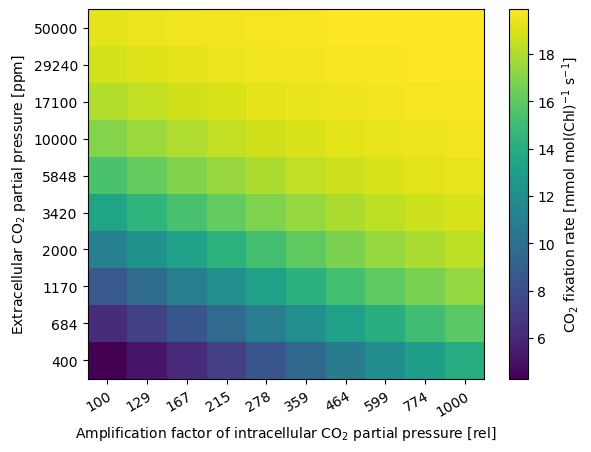

In [6]:
if settings["CO2_fluxes_spectral"]["plot"]:
    CO2s = fnc.load_obj_dated("rev_ss_CO2s_CO2vary", results_path)
    fig, ax = fnc.plot_heatmap(CO2s, clab=f"CO$_2$ fixation rate [mmol mol(Chl)$^{{-1}}$ s$^{{-1}}$]")
    ax.set_yticklabels(np.round(CO2s.index.to_numpy() * 1e6).astype(int))
    ax.set_xticklabels((f"{x:.0f}" for x in (CO2s.columns.to_numpy())), rotation=30, ha="right", rotation_mode='anchor')
    ax.set_xlabel("Amplification factor of intracellular CO$_2$ partial pressure [rel]")
    ax.set_ylabel("Extracellular CO$_2$ partial pressure [ppm]")

# Test State Transition Models (Figures 4b, 4c, & 12)
## Include a PBS detachment model only detaching from PSII

## State Transition Models PAM (Figure 4b)

In [10]:
m, y0 = get_model()

updating state transitions to hill
updating Flv to hill
updating CCM to pH dependency
updating CBB to Michaelis Menten
updating light representation with OCP
updating NQ to Michaelis Menten
Consistency checks added, this might slow the model down.
If the model works fine, set check_consistency=False


In [11]:
# Alter models with the tested state transition mechanisms
def remove_statetransitions_default(m, y0):
    m.remove_reactions(["vPSIIunquench", "vPSIIquench"])

    # Adapt y0
    y0["PSII"] = m.get_parameter("PSIItot")
    return m, y0


# PBS detachment model
def vPBS_detach(Q_ox, PBS_free, Q_red, kPBS_detach, kPBS_attach, PBS_freemax):
    return rf.reversible_mass_action_2_2((PBS_freemax-PBS_free), Q_ox, PBS_free, Q_red, kPBS_detach, kPBS_attach)

def update_statetransitions_detachpbs1(m, y0):
    # Remove old description
    m, y0 = remove_statetransitions_default(m, y0)

    # Adapt y0
    y0["PBS_PS1"] = 0.45
    y0["PBS_PS2"] = 0.55

    # Add new parameters and functions
    m.add_parameters({
        "kPBS_detach":1e-3,
        "kPBS_attach":1e-3,
        "PBS_freemax":0.5
    })

    m.add_reaction_from_args(
        rate_name="vPBS_detach",
        function=vPBS_detach,
        stoichiometry={"PBS_PS1": -1, "PBS_PS2":-1},
        args=["Q_ox", "PBS_free", "Q_red", "kPBS_detach", "kPBS_attach", "PBS_freemax"],
    )

    return m, y0

def update_statetransitions_detachpbs_PSIIonly(m, y0):
    # Remove old description
    m, y0 = remove_statetransitions_default(m, y0)

    # Adapt y0
    y0["PBS_PS1"] = 0.45
    y0["PBS_PS2"] = 0.55

    # Add new parameters and functions
    m.add_parameters({
        "kPBS_detach":1e-3,
        "kPBS_attach":1e-3,
        "PBS_freemax":0.5
    })

    m.add_reaction_from_args(
        rate_name="vPBS_detach",
        function=vPBS_detach,
        stoichiometry={"PBS_PS2":-1},
        args=["Q_ox", "PBS_free", "Q_red", "kPBS_detach", "kPBS_attach", "PBS_freemax"],
    )

    return m, y0

# PBS mobile model
def vPBS_mobile(Q_ox, PBS_PS1, Q_red, PBS_PS2, kPBS_toPS1, kPBS_toPS2, PBS_PS1min, PBS_PS2min):
    return rf.reversible_mass_action_2_2(
        (PBS_PS2 - PBS_PS2min), Q_red, 
        (PBS_PS1 - PBS_PS1min), Q_ox, 
        kPBS_toPS1, kPBS_toPS2
    )

def update_statetransitions_mobilepbs(m, y0):
    # Remove old description
    m, y0 = remove_statetransitions_default(m, y0)

    # Adapt y0
    y0["PBS_PS1"] = 0.45
    y0["PBS_PS2"] = 0.55

    # Add new parameters and functions
    m.add_parameters({
        "kPBS_toPS1":1e-3,
        "kPBS_toPS2":1e-3,
        "PBS_PS1min": 0.35, 
        "PBS_PS2min": 0.45,
    })

    m.add_reaction_from_args(
        rate_name="vPBS_mobile",
        function=vPBS_mobile,
        stoichiometry={"PBS_PS1": 1, "PBS_PS2":-1},
        args=["Q_ox", "PBS_PS1", "Q_red", "PBS_PS2", "kPBS_toPS1", "kPBS_toPS2", "PBS_PS1min", "PBS_PS2min"],
    )

    return m, y0

# Spillover model
def vspillover(spill, Q_red, Q_ox, kspill, kunspill, spillmax):
    return rf.reversible_mass_action_2_2(spillmax-spill, Q_red, spill, Q_ox, kspill, kunspill)

def ps_normabsorption_spill(time, PBS_PS1, PBS_PS2, spill, complex_abs, PSItot, PSIItot, lcf):
    light_ps1 = (complex_abs["ps1"] + complex_abs["pbs"] * PBS_PS1) / PSItot
    light_ps2 = (complex_abs["ps2"] + complex_abs["pbs"] * PBS_PS2) / PSIItot

    if isinstance(light_ps2, float) and isinstance(time, np.ndarray):
        light_ps1 = np.repeat(light_ps1, len(time))
        light_ps2 = np.repeat(light_ps2, len(time))

    return (light_ps1 + spill * light_ps2) * lcf, ((1-spill) * light_ps2) * lcf

def ps_normabsorption_spill(time, PBS_PS1, PBS_PS2, spill, complex_abs, PSItot, PSIItot, lcf):
    light_ps1 = (complex_abs["ps1"] + complex_abs["pbs"] * PBS_PS1) / PSItot
    light_ps2 = (complex_abs["ps2"] + complex_abs["pbs"] * PBS_PS2) / PSIItot

    if isinstance(light_ps2, float) and isinstance(time, np.ndarray):
        light_ps1 = np.repeat(light_ps1, len(time))
        light_ps2 = np.repeat(light_ps2, len(time))

    return (light_ps1 + spill * light_ps2) * lcf, ((1-spill) * light_ps2) * lcf

def update_statetransitions_spillover(m, y0):
    # Remove old description
    m, y0 = remove_statetransitions_default(m, y0)

    # Add new parameters and functions
    m.add_compound("spill")
    y0["spill"] = 0

    m.add_parameters({
        "kspill": 1e-5,
        "kunspill" :1e-5,
        "spillmax": 0.1  
    })

    m.add_reaction_from_args(
        rate_name="vspillover",
        function=vspillover,
        stoichiometry={"spill": 1},
        args=["spill", "Q_red", "Q_ox", "kspill", "kunspill", "spillmax"],
    )

    m.update_algebraic_module(
        module_name="ps_normabsorption",
        function=ps_normabsorption_spill,
        args=["time", "PBS_PS1", "PBS_PS2", "spill", "complex_abs", "PSItot", "PSIItot", "lcf"],
        check_consistency=False,
    )

    m.update_algebraic_module(  # >> changed: added <<
        module_name="ps_normabsorption_ML",
        function=ps_normabsorption_spill,
        args=[
            "time",
            "PBS_PS1",
            "PBS_PS2",
            "spill",
            "complex_abs_ML",
            "PSItot",
            "PSIItot",
            "lcf"
        ],
        check_consistency=False,
    )

    return m, y0

In [12]:
# Recalculate a run simulation with altered parameters
# Intended only for recalculating fluorescence under different measuring light
def recalculate_with_altered_parameters(sim, parameters, recalc_fluxes=False, recalc_full_results=False):
    s = sim.copy()
    s.full_results = None

    for i in range(len(s.simulation_parameters)):
        new_param = s.simulation_parameters[i].copy()
        new_param.update(parameters)
        s.simulation_parameters[i] = new_param
    
    if recalc_fluxes:
        s.fluxes = None
        s._calculate_fluxes()
    
    if recalc_full_results:
        s.full_results = None
        s._calculate_full_results()

    return s

# Calculate the relative difference in fluorescence with altered measuring light
def relative_fluo_diff(sims, sims_blueML):
    res = {}
    for nam in sims:
        # Get the relative fluorescences and calculate the RMSE
        fluo = sims[nam].get_full_results_df()["Fluo"]
        fluo_blueML = sims_blueML[nam].get_full_results_df()["Fluo"]

        fluo_diff = (fluo/fluo.max()) - (fluo_blueML/fluo_blueML.max())
        rmse = np.sqrt(np.mean(fluo_diff**2))
        res[nam] = rmse
    return res

# Simulate a PAM experiment for the state transitions models
def dummy(m,y0):
    return m, y0

def simulate_statetransition_models(models, loadsim = False, savesim=False):
    sims = {}
    for nam, model in models.items():
        if not loadsim:
            m,y0 = get_model(check_consistency=False, verbose=False, pbs_behaviour=model["pbs_behaviour"])
            m,y0 = model["fun"](m, y0)

            m.update_parameters(model["param"])
            y0 = fnc.get_steadystate_y0(m, y0)

            # Initialise the model
            s=Simulator(m)
            s.initialise(y0)

            # Simulate the appropriate protocol
            protocol = create_protocol_NPQ_short(*make_lights())

            s = fnc.simulate_protocol(s, protocol)
            if savesim:
                fnc.save_Simulator_dated(s, f"rev_pamsim_{nam}", results_path)
        else:
            s = fnc.load_Simulator_dated(f"rev_pamsim_{nam}", results_path)

        sims[nam] = s
    return sims


In [13]:
# Plotting functions
def add_phasebox(ax, t_start, t_end, text, height, ylow=1, adj_plotheight=False):
    box = Rectangle(
        [t_start, ylow],
        t_end-t_start,
        height,
        fill=False,
        ec="k",
    )
    ax.add_patch(box)
    ax.text(
        t_start + 0.5*(t_end-t_start),
        ylow+0.5*height,
        text,
        ha="center",
        va="center"
    )
    if adj_plotheight:
        ax.set_ylim(ymax=ax.get_ylim()[1]+height)
    return ax

def add_insetbox(ax, xmin, xmax, ymin, ymax, adj_plotheight=None):
    height = ymax-ymin
    box = Rectangle(
        [xmin, ymin],
        xmax-xmin,
        height,
        fill = False,
        fc="w",
        ec="k",
        transform = ax.transAxes
    )
    ax.add_patch(box)
    if adj_plotheight is not None:
        adj_y = np.array(ax.get_ylim()) + np.array(adj_plotheight)
        ax.set_ylim(adj_y)
    return ax

def annotate_phases_statetrans(ax):
    cycles = np.array([3,3,15,15])
    times = np.cumsum(cycles * 20)
    ax = add_phasebox(ax, 0, times[0], "D", 0.05, 1.02, adj_plotheight=True)
    ax = add_phasebox(ax, times[0], times[1], "S1", 0.05, 1.02)
    ax = add_phasebox(ax, times[1], times[2], "S2", 0.05, 1.02)
    ax = add_phasebox(ax, times[2], times[3], "S1", 0.05, 1.02)

    return ax

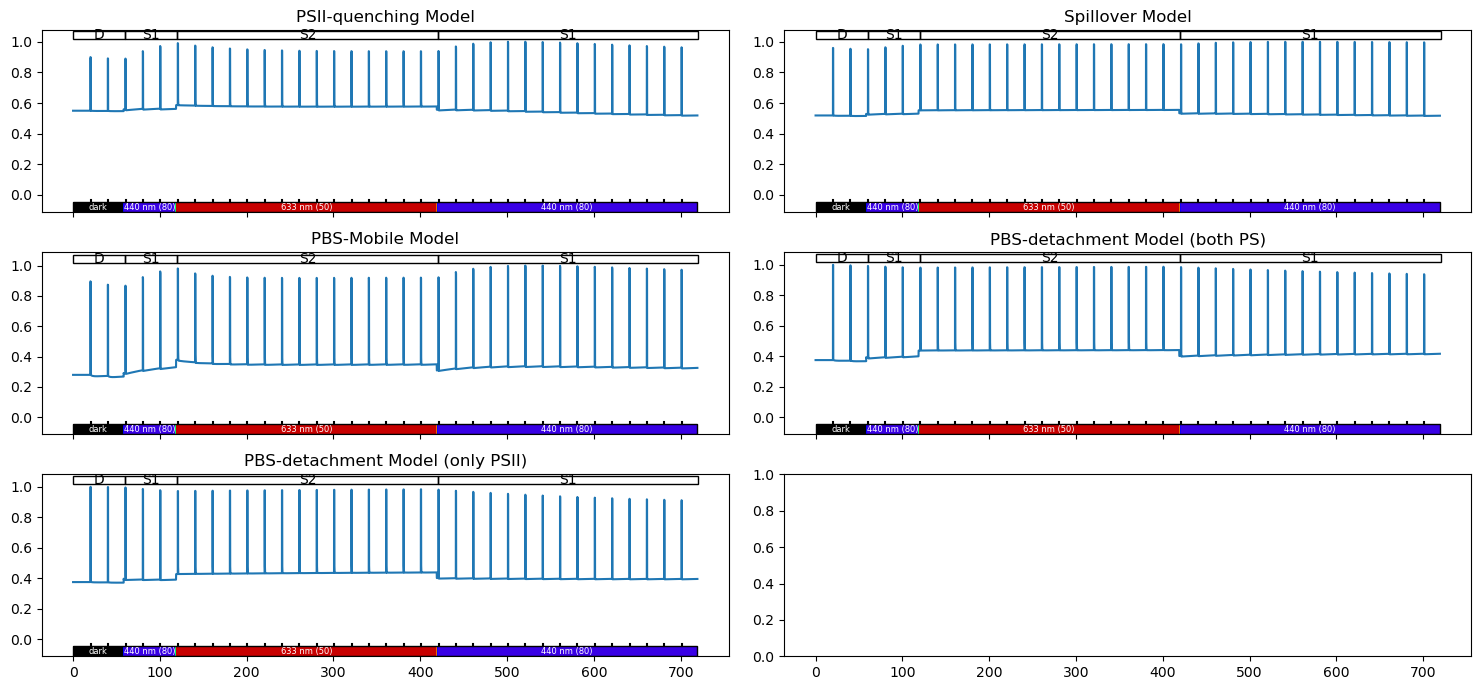

In [14]:
# Define the state transition models with the necessary parameters
models = {
    "mnost":{
        "pbs_behaviour": "static",
        "fun": remove_statetransitions_default,
        "param":{},
        "param_bounds":{}
    },
    "m0":{
        "pbs_behaviour": "static",
        "fun": dummy,
        "param":{
            "kUnquench": 0.1,
            "kQuench": 2e-3,
            "KMUnquench": 0.2,
        },
        "param_bounds":{
            "kUnquench": (0.01, 1),
            "kQuench": (2e-2, 2e-4),
            "KMUnquench": (0.01,0.3) ,
        }
    },
    "mspill":{
        "pbs_behaviour": "static",
        "fun": update_statetransitions_spillover,
        "param":{
            "kspill": 5e-3,
            "kunspill" :5e-4,
            "spillmax": 0.3 
        },
        "param_bounds":{
            "kspill": (5e-4, 5e-2),
            "kunspill": (5e-5, 5e-3),
            "spillmax": (0.1,0.6) ,
        }
    },
    "mpbsd":{
        "pbs_behaviour": "dynamic",
        "fun": update_statetransitions_detachpbs1,
        "param":{
            "kPBS_detach":1e-4,
            "kPBS_attach":1e-3,
            "PBS_freemax":0.1
        },
        "param_bounds":{
            "kPBS_detach": (1e-5, 1e-3),
            "kPBS_attach": (1e-4, 1e-2),
            "PBS_freemax": (0.01,0.3),
        }
    },
    "mpbsd2":{
        "pbs_behaviour": "dynamic",
        "fun": update_statetransitions_detachpbs_PSIIonly,
        "param":{
            "kPBS_detach":1e-4,
            "kPBS_attach":1e-3,
            "PBS_freemax":0.1
        },
        "param_bounds":{
            "kPBS_detach": (1e-5, 1e-3),
            "kPBS_attach": (1e-4, 1e-2),
            "PBS_freemax": (0.01,0.3),
        }
    },
    "mpbsm":{
        "pbs_behaviour": "dynamic",
        "fun": update_statetransitions_mobilepbs,
        "param":{
            "kPBS_toPS1":5e-3,
            "kPBS_toPS2":1e-3,
            "PBS_PS1min": 0.25, 
            "PBS_PS2min": 0.35,
        },
        "param_bounds":{
            "kPBS_toPS1": (5e-4, 5e-2),
            "kPBS_toPS2": (1e-4, 1e-2),
            "PBS_PS1min": (0, 0.5),
            "PBS_PS2min": (0, 0.5)
        }
    }
}

# Simulate the models
sims = simulate_statetransition_models(
    models, 
    loadsim=not settings["state_transitions_PAM"]["recalculate"], 
    savesim=settings["state_transitions_PAM"]["recalculate"]
)

if settings["state_transitions_PAM"]["plot"]:
    titles = {
        "m0": "PSII-quenching Model",
        "mspill": "Spillover Model",
        "mpbsm": "PBS-Mobile Model",
        "mpbsd": "PBS-detachment Model (both PS)",
        "mpbsd2": "PBS-detachment Model (only PSII)",
    }

    # Plot of PAM traces
    fig, axes = plt.subplots(3,2, figsize=(15,7), sharey=False, sharex = True)

    axdims = pd.DataFrame(index=range(5), columns=["ymin","ymax"])

    for i, (ax, nam) in enumerate(zip(axes.flatten(), titles)):
        s = sims[nam]
        if nam == "mnost":
            continue

        # Fluorescence plot
        fluo = s.get_full_results_df()["Fluo"]
        ax.plot(fluo / fluo.max())
        axdims.iloc[i] = ax.get_ylim()
        ax.set_title(titles[nam])

        ax = annotate_phases_statetrans(ax)
        yadj = 0.08
        ax.set_ylim(ymin=0)
        # ax = add_insetbox(ax, 0.69, 0.975, 0.01 + yadj, 0.2 + yadj, adj_plotheight=[-0.15, 0])
        ax = fnc.add_lightbar(s, ax, 1000, color="mono", remove_pulses=True, scale="log", size=0.06, time_offset=0, spectrum_maskalpha=0, pad_top=0.08, annotation_twoline=False, annotation_light_c="w", annotation_size = 6)
    fig. tight_layout()

    fnc.savefig_dated(fig, "rev_stmodels_pam", type=plot_format, path=figure_path)

## State Transition Models Analysis (Figure 4c & 12)

In [15]:

# Calculate steady state Q_reds under a range of parameter values
if settings["state_transitions_analysis"]["recalculate"]:
    print("Calculating Qreds and Fms...")
    Q_reds, Fms = get_parametervariant_outputs( # Took 12h with 10 sample points
        models, 
        sims, 
        n=10, 
        multiprocessing=settings["general"]["multiprocessing"],
        max_workers=settings["general"]["max_workers"],
    ) 
    # Recalculate the fluorescence trace with blue measuring light
    sims_blueML = {k:recalculate_with_altered_parameters(s, {"pfd_ML": lip.light_gaussianLED(450,1,1e-3)}, recalc_full_results=True) for k,s in sims.items()}

    fnc.save_obj_dated(Q_reds, "rev_stmodels_Qreds", results_path)
    fnc.save_obj_dated(Fms, "rev_stmodels_Fms", results_path)
    fnc.save_Simulator_dated(sims_blueML, "rev_stmodels_blueML", results_path)
elif settings["state_transitions_analysis"]["plot"]:
    print("Loading Qreds and Fms...")
    Q_reds = fnc.load_obj_dated("rev_stmodels_Qreds", results_path)
    Fms = fnc.load_obj_dated("rev_stmodels_Fms", results_path)
    sims_blueML = fnc.load_Simulator_dated("rev_stmodels_blueML", results_path)

if settings["state_transitions_analysis"]["plot"]:
    # Calculate the relative alleviation in PQ reduction
    Q_reds_rel = {k:(Q_reds["mnost"]-v[np.invert(np.isnan(v))])/Q_reds["mnost"] for k,v in Q_reds.items() if k != "mnost"}

    # Calculate the RMSE of fluorescence under dfferent measuring lights
    bluefluo_rmse = relative_fluo_diff(sims, sims_blueML)

Calculating Qreds and Fms...


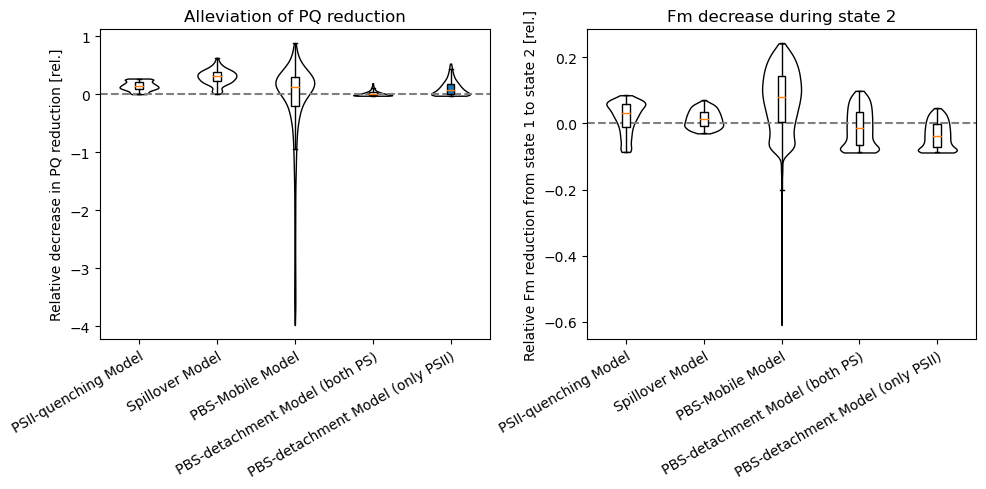

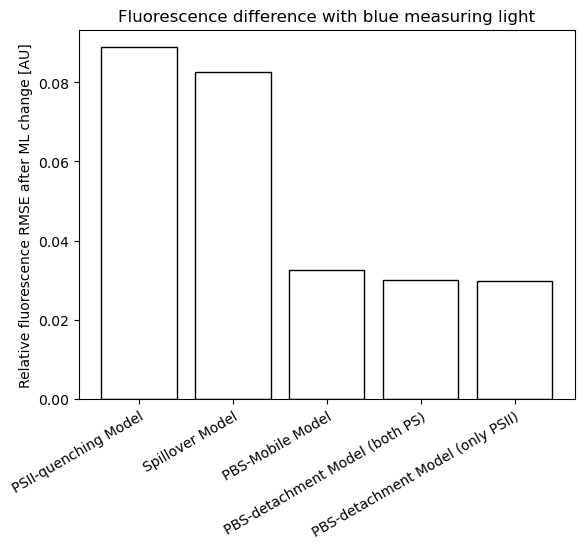

In [16]:
if settings["state_transitions_analysis"]["plot"]:
    # Plot of PQ reduction alleviation
    fig, axes = plt.subplots(1,2, figsize=(10,5))
    ax=axes[0]
    ax.axhline(0, linestyle="--", c="grey")
    bp = ax.boxplot([Q_reds_rel[x] for x in titles], patch_artist=True,
                    showmeans=False, showfliers=False, widths=0.1)
    bp_colors = np.repeat("white", 4)
    for patch, color in zip(bp['boxes'], bp_colors):
        patch.set_facecolor(color)

    bp = ax.violinplot([Q_reds_rel[x] for x in titles], showextrema=False)
    for pc in bp['bodies']:
        pc.set_facecolor('white')
        pc.set_edgecolor('black')
        pc.set_alpha(1)

    ax.set_title("Alleviation of PQ reduction")
    ax.set_xticks(range(1,6), titles.values(),rotation=30, ha="right", rotation_mode='anchor')
    ax.set_ylabel("Relative decrease in PQ reduction [rel.]")


    # Plot of reduction in fluorescence level
    ax=axes[1]
    data = [Fms[x][np.invert(np.isnan(Fms[x]))] for x in titles]
    ax.axhline(0, linestyle="--", c="grey")
    bp = ax.boxplot(data, patch_artist=True,
                    showmeans=False, showfliers=False, widths=0.1)
    bp_colors = np.repeat("white", 5)
    for patch, color in zip(bp['boxes'], bp_colors):
        patch.set_facecolor(color)

    bp = ax.violinplot(data, showextrema=False)
    for pc in bp['bodies']:
        pc.set_facecolor('white')
        pc.set_edgecolor('black')
        pc.set_alpha(1)

    ax.set_title("Fm decrease during state 2")
    ax.set_xticks(range(1,6), titles.values(),rotation=30, ha="right", rotation_mode='anchor')
    ax.set_ylabel("Relative Fm reduction from state 1 to state 2 [rel.]")

    fig.tight_layout()
    fig. subplots_adjust(wspace=0.25)
    fnc.savefig_dated(fig, "rev_stmodels_analysis", type=plot_format, path=figure_path)

    # Plot of RMSE from Fluorescence calculation with blue ML
    fig, ax = plt.subplots()
    ax.bar(range(5) ,[bluefluo_rmse[x] for x in titles], fill=False) 

    ax.set_title("")
    ax.set_xticks(range(5),list(titles.values()),rotation=30, ha="right", rotation_mode='anchor')
    ax.set_ylabel("Relative fluorescence RMSE after ML change [AU]")
    ax.set_title("Fluorescence difference with blue measuring light")
    fnc.savefig_dated(fig, "rev_stmodels_FblueRMSE", type=plot_format, path=figure_path, bbox_inches="tight")

# Productivity of different sinks with varying light (Figure 5b, 5c, & 13)
## With cells adapted with data of Zavrel (2013) <br> Old implementation with Mass Action sinks


In [4]:
m,y0 = get_model()

updating state transitions to hill
updating Flv to hill
updating CCM to pH dependency
updating CBB to Michaelis Menten
updating light representation with OCP
updating NQ to Michaelis Menten
Consistency checks added, this might slow the model down.
If the model works fine, set check_consistency=False


## Variable Sink Production under Monochromatic Lights (Figure 5b & 5c)

In [5]:
def get_PS_concentration(f_PS1_PS2, fraction_is_monomers=False, output_is_monomers=False):
    if not fraction_is_monomers:
        n_chl_PSII = ( # [chl PSII^-1] number of chlorophyll molecules per PSII dimer complex(Fuente2021)
            35 * # [chl PSII^-1] number of chlorophyll molecules per PSII complex(Fuente2021)     
            2) # [unitless] two PSII monomers per dimer
        n_chl_PSI = ( # [chl PSI^-1] number of chlorophyll molecules per PSI trimer complex (Fuente2021)     
            96 * # [chl PSI^-1] number of chlorophyll molecules per PSI complex (Fuente2021)     
            3) # [unitless] three PSI monomers per trimer
    else:
        n_chl_PSII = 35 # [chl PSII^-1] number of chlorophyll molecules per PSII complex(Fuente2021)     
        n_chl_PSI = 96 # [chl PSI^-1] number of chlorophyll molecules per PSI complex (Fuente2021)     

    f_PSI_PStot = 1 / (1 + 1/f_PS1_PS2) # [PSII PStot^-1] fraction of PSIIs compared to the whole number of photosystems
    f_PSII_PStot = 1 - f_PSI_PStot # [PSI PStot^-1] fraction of PSIs compared to the whole number of photosystems

    c_PSIItot = ( # [mmol mol(Chl)^-1] total concentration of photosystem 2 complexes (ADAPT DATA SET)
        (f_PSII_PStot * n_chl_PSII) / (f_PSII_PStot * n_chl_PSII + f_PSI_PStot * n_chl_PSI) *  # [unitless] fraction of chlorophylls bound in PSII complexes
        1/n_chl_PSII * 1e3) # [PSII chl^-1] * [mmol mol^-1]
    c_PSItot = ( # [mmol mol(Chl)^-1] total concentration of photosystem 1 complexes (ADAPT DATA SET)
        (f_PSI_PStot * n_chl_PSI) / (f_PSII_PStot * n_chl_PSII + f_PSI_PStot * n_chl_PSI) *  # [unitless] fraction of chlorophylls bound in PSII complexes
        1/n_chl_PSI * 1e3) # [PSI chl^-1] * [mmol mol^-1]

    if not output_is_monomers and fraction_is_monomers:
        c_PSIItot = c_PSIItot/2
        c_PSItot = c_PSItot/3

    return {"PSIItot":c_PSIItot, "PSItot":c_PSItot}

def get_pbs_attachment(df, light, rel_fluo):
    res = df.loc[:,light] / pd.Series(rel_fluo)
    return (res / res.sum()).to_dict()

def normalise_concentrations(dat_conc):
    # Convert to [mg mg(Chla)^-1]
    dat_conc = dat_conc.div(dat_conc.loc['chla',:]) # convert to [mg mg(Chla)^-1]
    return dat_conc

def _get_strain_parameters(df_pigments, df_PBS, df_PS1_PS2, growthlight, pbs_relfluo, fraction_is_monomers=True, output_is_monomers=False):
    # Get the PBS attachment and pigments
    pbs = get_pbs_attachment(df_PBS, growthlight, pbs_relfluo)

    pigment = df_pigments.loc[:,growthlight]

    # Get the photosysystems concentration form the ratio and chla content
    ps_conc = get_PS_concentration(float(df_PS1_PS2.loc[:,growthlight]), fraction_is_monomers=fraction_is_monomers, output_is_monomers=output_is_monomers)

    # Return a combines parameter dict
    res = {"pigment_content": pigment}
    res.update(pbs)
    res.update(ps_conc)
    
    return res

def get_strain_parameters(dat, pbs_relfluo, ps_fraction_is_monomers=True, ps_output_is_monomers=False):
    # Get the pigments
    df_pigments = dat.loc[["Chlorophyll a", "β-carotene ", "Allophycocyanin", "Phycocyanin"], :]
    df_pigments.index = ['chla', 'beta_carotene', 'allophycocyanin', 'phycocyanin']
    df_pigments = normalise_concentrations(df_pigments)

    # Get Phycobilisome attachment
    df_PBS = dat.loc[["PBS attached to PSII", "PBS attached to PSI", "PBS uncoupled - disattached from both PSI and PSII"], :]
    df_PBS.index = ["PBS_PS2", "PBS_PS1", "PBS_free"]
    
    # Get PS1:PS2 ratio
    df_PS1_PS2 = dat.loc[["PSI / PSII"],:]

    res = {}
    for wl in dat.columns:
        res[wl] = _get_strain_parameters(df_pigments, df_PBS, df_PS1_PS2, wl, pbs_relfluo)
    return res

In [6]:
# Get the parameters defining different strains 
# (pigments, photosystems ratios, PBS attachment)
strains= pd.read_csv("../Code/data/Strainparameters_Zavrel2021.csv", header=0,skiprows=1, index_col=0).loc[:,"435":"687"]
strains.columns = strains.columns.astype(str)

strain_params = get_strain_parameters(
    strains, 
    {"PBS_PS2":1, "PBS_PS1":1, "PBS_free":10},
    ps_fraction_is_monomers=True,
    ps_output_is_monomers=False
)

In [7]:
# Read the Rodrigues isoprene data
rodrigues2023 = pd.read_csv("../Code/data/Isopreneproduction_Rodrigues2023.csv", index_col=0)

# Add the Rodrigues strain parameters (only pigment content)
for wl, row in rodrigues2023.iterrows():
    # Make a key from the wavelength and intensity
    key = f'{str(int(np.round(wl)))}_{row.loc["Light_intensity_umol_m2_s"].round().astype(int).astype(str)}'
    params = row.loc[["mean_Chla_g_gChla", "mean_Beta_carotene_g_gChla", "mean_Allophycocyanin_g_gChla", "mean_Phycocyanin_g_gChla"]]
    params.index = ['chla', 'beta_carotene', 'allophycocyanin', 'phycocyanin']

    strain_params[key] = {"pigment_content": params}

In [8]:
# Add a sink reaction with Mass Action kinetics to the model
def vsink(*X):
    res = 1
    for x in X:
        res *=x
    return res

def vcap(S, k, thresh):
    v = np.array(k * (S - thresh))
    v = v.reshape(-1)
    v[v<0] = 0
    return v

def add_sink(m, stoich, k=10):
    # Make a copy of the model, in case the mca adaption version should not be applied to the original model
    m = m.copy()

    # Add the sink parameters and cap 3PGA, ATP and NADPH
    m.add_parameters({
        "kSink": k,
    })

    for cap in ["3PGA", "ATP", "NADPH"]:
        # Cap 3PGA, ATP and NADPH levels
        # Set the stoichiometry
        if cap == "NADPH":
            cap_stoich = {
            "NADPH": -1,
            "Ho": -1/m.get_parameter("bHo"),
            }
        else:
            cap_stoich = {cap:-1}

        # Set the cap level
        if cap == "3PGA":
            cap_thresh = 1000
        elif cap == "ATP":
            cap_thresh = 0.95 * m.get_parameter("AP_tot")
        elif cap == "NADPH":
            cap_thresh = 0.95 * m.get_parameter("NADP_tot")


        m.add_parameters({
            f"kCap_{cap}": 10000,
            f"threshCap_{cap}": cap_thresh,
        })
        
        m.add_reaction_from_args(
            rate_name=f"vCap_{cap}",
            function=vcap,
            stoichiometry=cap_stoich,
            args=[cap, f"kCap_{cap}", f"threshCap_{cap}"]
        )

    # Add the sink reaction
    modelstoich = {k:v for k,v in stoich.items() if k in m.get_compounds()}
    vargs = [k for k,v in stoich.items() if v<0]

    if len(modelstoich) != len(vargs):
        raise ValueError("stoichiometry unbalanced")

    m.add_reaction_from_args(
        rate_name=f"vsink",
        function=vsink,
        stoichiometry=modelstoich,
        args=["kSink"] + vargs
    )
    return m

# Get the steady-state sink production
def get_sink_mca_model(stoich, param_update={}):
    m_MCA,y0 = get_model(verbose=False, check_consistency=False)

    # TEST Y0
    y0["PG"] = 0

    m_MCA = add_sink(m_MCA, stoich, k=5000)
    s_MCA = Simulator(m_MCA)
    s_MCA.update_parameters(param_update)
    s_MCA.initialise(y0)
    return s_MCA

def get_sink_production(stoich, strain_params=None, param_update=None, light_param=None):
    # Create model
    s_MCA = get_sink_mca_model(stoich, param_update)

    # Adjust the light
    # If the strain parameters are from rodrigues, the first light param will be <wavelength>_<groowthlight intensity>
    wl, intens = light_param[:2]

    if ("_" in wl):
        wl = wl.split("_")[0]

    light = lip.light_gaussianLED(int(wl), intens, spread=1e-3)
    s_MCA.update_parameter("pfd", light)

    if strain_params is not None:
        s_MCA.update_parameters(strain_params[light_param[0]])

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        s_MCA, t, y = simulate_to_steady_state_custom(
            s_MCA,
            simulation_kwargs={
                "t_end": 1e6,
                "tolerances": [[["CBBa", "PSII", "OCP"], 1e-8], [None, 1e-6]],
                "verbose": True,
            },
            rel_norm=True,
            return_simulator=True,
            **fnc.simulator_kwargs["loose"],
        )
        if t is None:
            return np.nan
        else:
            return s_MCA.get_fluxes_dict()["vsink"][-1]

In [ ]:
snk = sinks["terpenes"]

stoich = snk.get("stoich")
param_update = snk.get("param_update", {})

light_param = (520, 400)

# Create model
s_MCA = get_sink_mca_model(stoich, param_update)

# Adjust the light
light = lip.light_gaussianLED(*light_param, spread=1e-3)
s_MCA.update_parameter("pfd", light)

if strain_params is not None:
    s_MCA.update_parameters(strain_params[light_param[0]])

s_MCA.simulate(1e6, **fnc.simulator_kwargs["loose"])

In [9]:
# Different possible sink reactions with stoichiometries
# Different possible sink reactions with stoichiometries
sinks = {
    "ATP":{
        "stoich": {"ATP":-1},
        "title": "ATP production rate (adapted)",
        "compound": "ATP"
    },
    "NADPH":{
        "stoich": {
            "NADPH": -1,
            "Ho": -1/m.get_parameter("bHo"),
        },
        "title": "NADPH production rate (adapted)",
        "compound": "NADPH"
    },
    "terpenes":{ # Stoichiometry according to Mills2020
        "stoich": {
            "ATP": -3,
            "NADPH": -1,
            "Ho": -5/m.get_parameter("bHo"),
            "Fd_ox": 4,
            "Fd_red":-4,
            "3PGA": -2,
        },
        "title": "Isoprene production (energy carrier & 3PGA, adapted)",
        "compound": "Isoprene"
    },
    "sucrose":{
        "stoich": {
            "NADPH": -2,
            "Ho": -2/m.get_parameter("bHo"),
            "ATP": -3,
            "3PGA": -2
        },
        "title": "Sucrose production (energy carrier & 3PGA, adapted)",
        "compound": "Sucrose"
    },
    "glycogen":{
        "stoich": {
            "NADPH": -1,
            "Ho": -1/m.get_parameter("bHo"),
            "ATP": -2,
            "3PGA": -1
        },
        "title": "Glycogen production (energy carrier & 3PGA, adapted)",
        "compound": "Glycogen"
    },
    # "highATP":{
    #     "stoich": {
    #         "NADPH": -1,
    #         "Ho": -1/m.get_parameter("bHo"),
    #         "ATP": -3,
    #         "3PGA": -1
    #     },
    #     "title": "Glycogen + 1 ATP"
    # },
}
sinks_AN = {
    # Only use ATP:NADPH ratio
    "ATP_noCBB":{
        "stoich": {"ATP":-1},
        "param_update":{"vCBB_max":0},
        "title": "ATP production (no CBB, adapted)",
        "compound": "ATP"
    },
    "NADPH_noCBB":{
        "stoich": {
            "NADPH": -1,
            "Ho": -1/m.get_parameter("bHo"),
        },
        "param_update":{"vCBB_max":0},
        "title": "NADPH production (no CBB, adapted)",
        "compound": "NADPH"
    },
    "terpenes_ratio":{ # Stoichiometry according to Mills2020
        "stoich": {
            "ATP": -19,
            "NADPH": -11,
            "Ho": -15/m.get_parameter("bHo"),
            "Fd_ox": 4,
            "Fd_red":-4,
        },
        "param_update":{"vCBB_max":0},
        "title": "Isoprene production (energy carrier ratio, no CBB, adapted)",
        "compound": "Isoprene"
    },
    "sucrose_ratio":{
        "stoich": {
            "NADPH": -12,
            "Ho": -12/m.get_parameter("bHo"),
            "ATP": -19,
        },
        "param_update":{"vCBB_max":0},
        "title": "Sucrose production (energy carrier ratio, no CBB, adapted)",
        "compound": "Sucrose"
    },
    "glycogen_ratio":{
        "stoich": {
            "NADPH": -6,
            "Ho": -6/m.get_parameter("bHo"),
            "ATP": -11,
        },
        "param_update":{"vCBB_max":0},
        "title": "Glycogen production (energy carrier ratio, no CBB, adapted)",
        "compound": "Glycogen"
    },
    # "highATP_ratio":{
    #     "stoich": {
    #         "NADPH": -6,
    #         "Ho": -6/m.get_parameter("bHo"),
    #         "ATP": -11,
    #     },
    #     "param_update":{"vCBB_max":0},
    #     "title": "Glycogen + 1 ATP  ATP:NADPH"
    # },
}

if settings["sink_production_monochrom"]["recalculate"]:
    # Calculate and plot the sink production for all strains in the zavrel and rodrigues data
    for i,_sinks in enumerate([sinks, sinks_AN]):
        if i == 0:
            intensities = np.concatenate((np.linspace(40, 400, 1).round().astype(int), [50, 100]))
        else:
            intensities = np.concatenate((np.linspace(40, 800, 1).round().astype(int), [50, 100]))

        for sink in _sinks:
            wavelength = list(strain_params.keys())

            light_params = np.meshgrid(wavelength, intensities)
            _light_params = zip(*[x.flatten() for x in light_params])

            _get_sink_production = partial(get_sink_production, _sinks[sink]["stoich"], strain_params, _sinks[sink].get("param_update", {}))

            if sys.platform in ["win32", "cygwin"] or not settings["general"]["multiprocessing"]:
                prods = np.array(list(map(_get_sink_production, _light_params)), dtype=float)
            else:
                with ProcessPoolExecutor(max_workers=settings["general"]["max_workers"]) as pe:
                    prods = np.array(list(pe.map(_get_sink_production, _light_params)), dtype=float)
            prods = prods.reshape(-1,len(wavelength))
            prods = pd.DataFrame(
                prods, 
                index=pd.Index(intensities, name="Intensity [µmol(Photons) m$^{-2}$ s$^{-1}$]"),
                columns=pd.Index(wavelength, name="Wavelength [nm]")
            )
            fnc.save_obj_dated(prods, f"rev_sink_{sink}_wi", results_path)



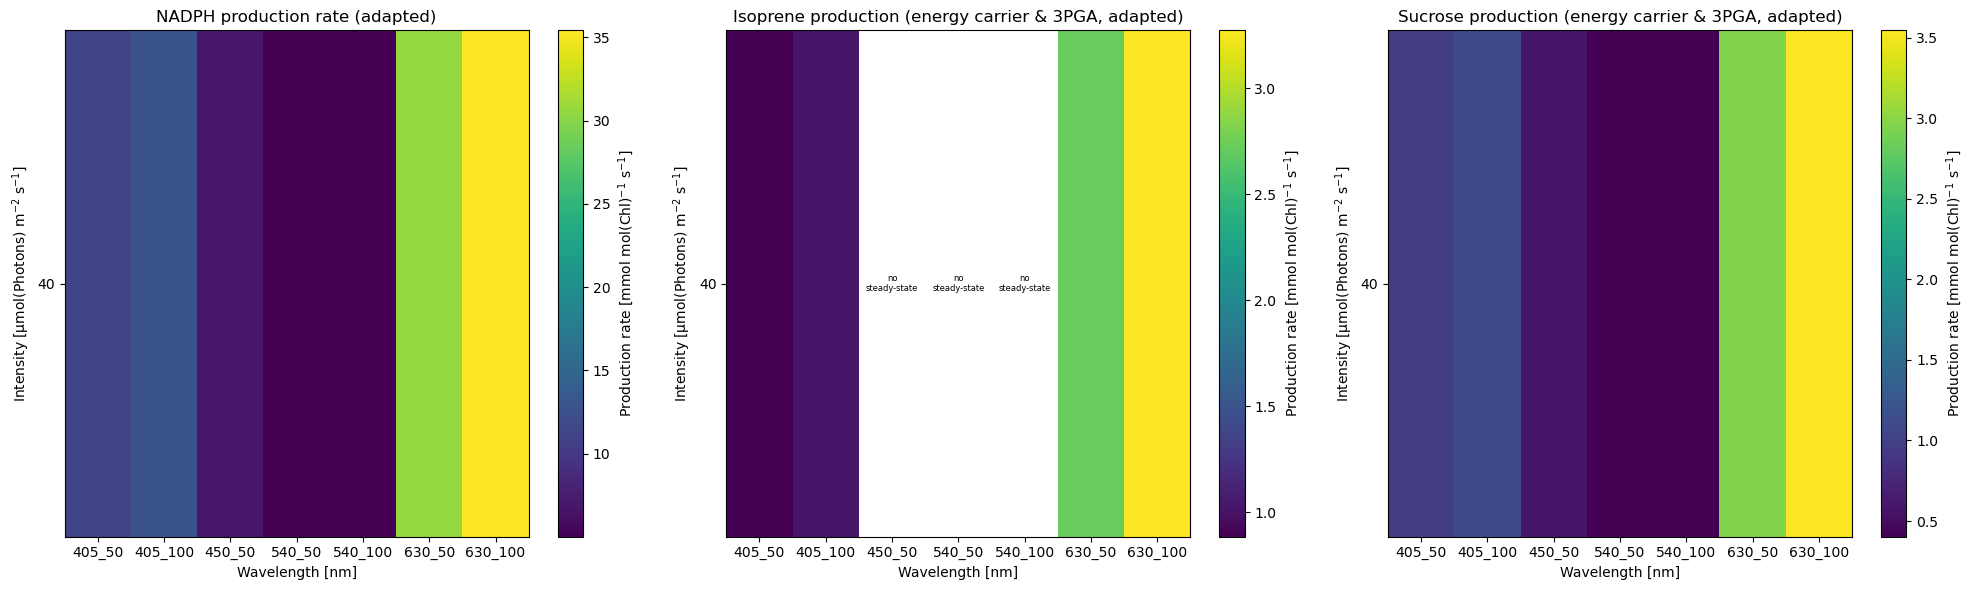

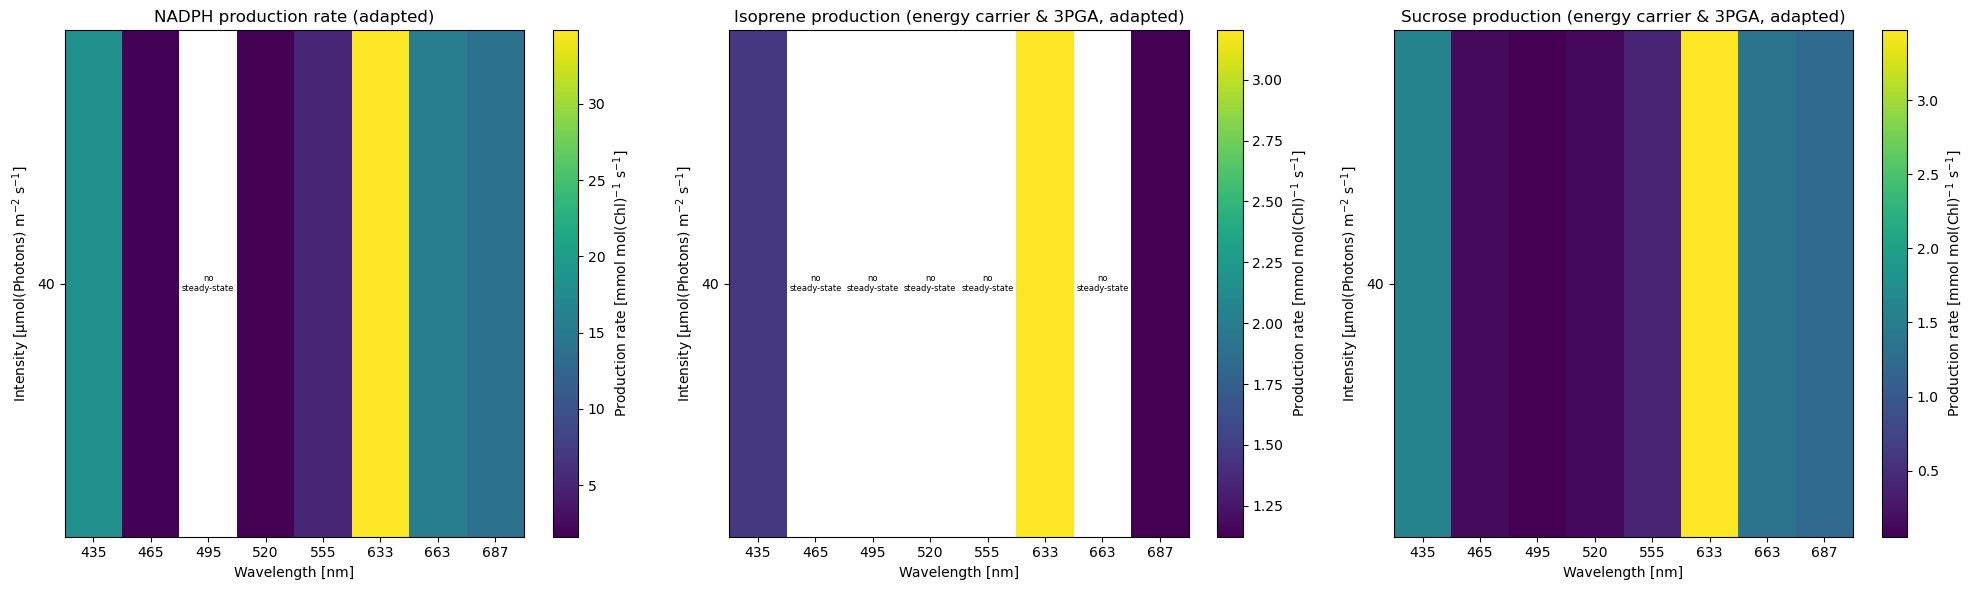

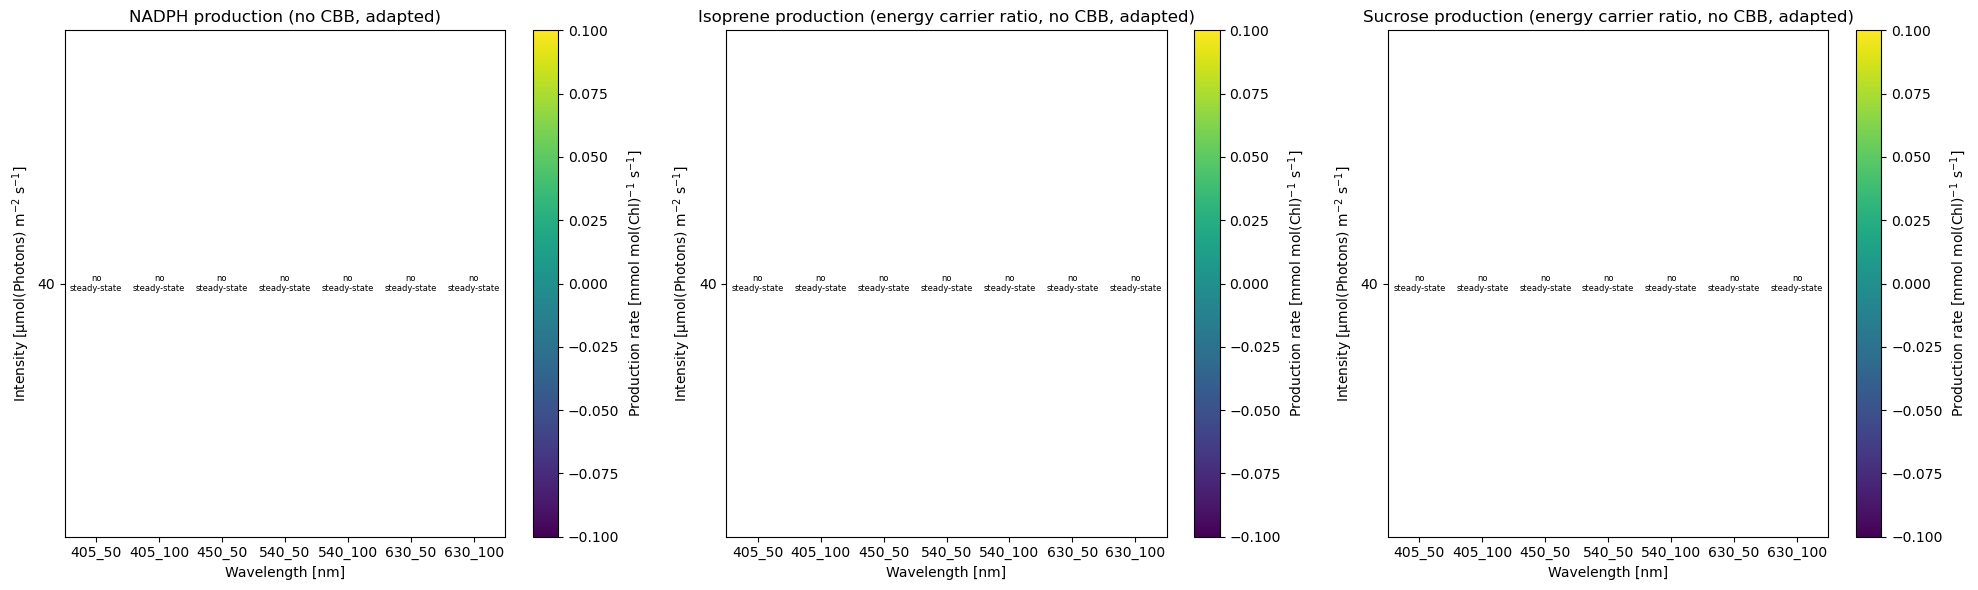

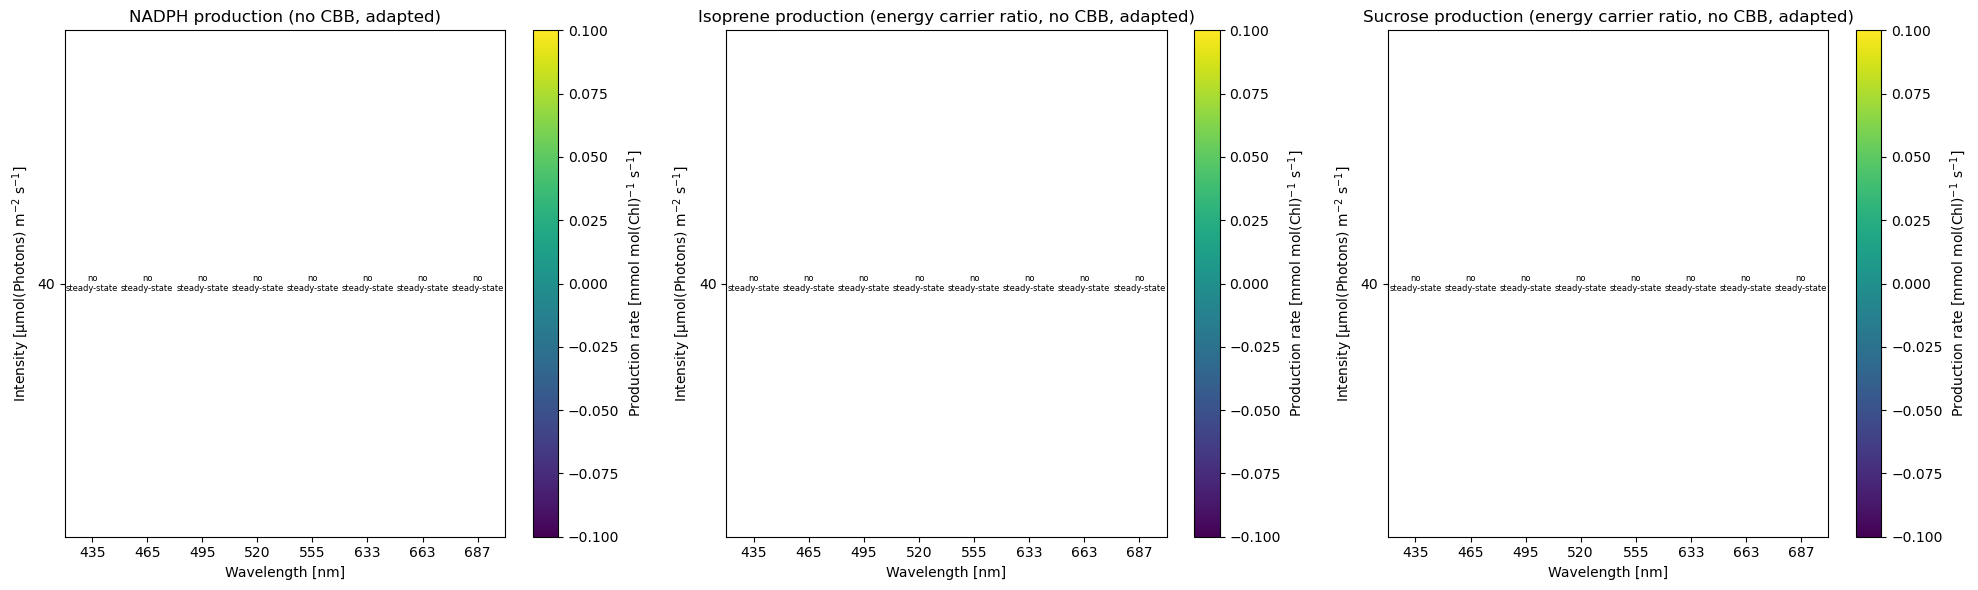

In [ ]:
if settings["sink_production_monochrom"]["plot"]:
    combined_plots = {
        "withCBB": ["NADPH", "terpenes", "sucrose"],
        "noCBB": ["NADPH_noCBB", "terpenes_ratio", "sucrose_ratio"]
    }

    for _sinks, nam in zip([sinks, sinks_AN], ["withCBB", "noCBB"]):
        # Loop through both sources for the strain parameters
        
        for strain_data in ["rodrigues2023", "zavrel2023"]:
            # Create a combined plot
            fig_com, axes_com = plt.subplots(1,3, figsize=(20,6)) #, sharex=True, sharey=True)
            for sink in _sinks:
                prods = fnc.load_obj_dated(f"rev_sink_{sink}_wi", results_path)

                if strain_data == "zavrel2023":
                    prods_sub = prods.iloc[:-2,:].loc[:,np.invert(prods.columns.str.contains("_"))]
                else:
                    prods_sub = prods.iloc[:-2,:].loc[:,prods.columns.str.contains("_")]

                # Single plot
                fig, ax = fnc.plot_heatmap(prods_sub, clab=f"Production rate [mmol mol(Chl)$^{{-1}}$ s$^{{-1}}$]")
                ax.set_title(_sinks[sink]['title'])
                ax = fnc.add_na_annotation(ax, prods_sub, 6)
                fig.tight_layout()
                fnc.savefig_dated(fig, f"{sink}prod_singlemonochr", type=plot_format, path=figure_path)
                plt.close()

                # Combined plot
                if sink in combined_plots[nam]:
                    ax_com = axes_com[combined_plots[nam].index(sink)]
                    fig, ax_com = fnc.plot_heatmap(prods_sub, clab=f"Production rate [mmol mol(Chl)$^{{-1}}$ s$^{{-1}}$]", ax=ax_com)
                    ax_com.set_title(_sinks[sink]['title'])
                    ax_com = fnc.add_na_annotation(ax_com, prods_sub, 6)
            
            fig_com.tight_layout()
            fnc.savefig_dated(fig_com, f"rev_sinkprod_{nam}_{strain_data}_singlemonochr", type=plot_format, path=figure_path)

NameError: name 'rodrigues2023' is not defined

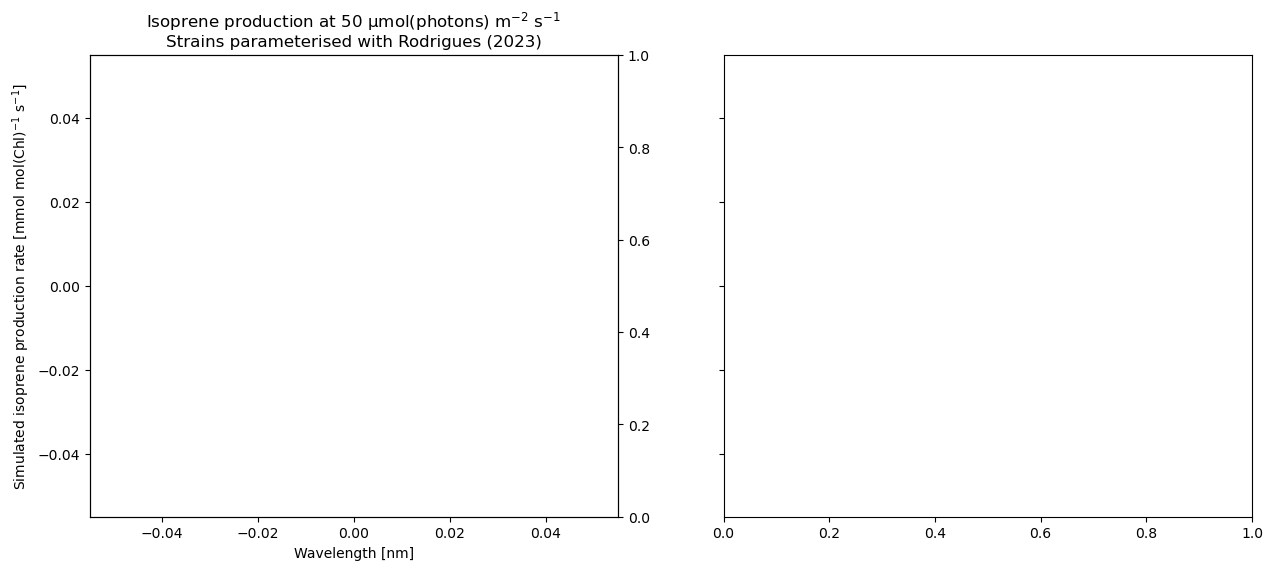

In [ ]:
# Select the measurement to be shown for isporene production
isoprene_columns = {
    "mean_Isoprene_umol_gDW_h": "µmol g(DW)$^{-1}$ h$^{-1}$",
    "mean_Isoprene_amol_cell_h": "amol cell$^{-1}$ h$^{-1}$"
}
isoprene_column = "mean_Isoprene_umol_gDW_h"


colors = ["k", "blue", "red"]

measured_intensities = [50, 100]

strain_data_titles = {
    "rodrigues2023":"Rodrigues (2023)", 
    "zavrel2023":"Zavrel (2023)"
}

for strain_data in strain_data_titles:
    fig, axes = plt.subplots(1,2, figsize = (15,6), sharey = True)
    for meas_int, ax in zip(measured_intensities, axes.flatten()):
        # prods = fnc.load_obj_dated(f"rev_sink_terpenes_wi", results_path)
        prods = fnc.load_obj_dated("rev_sink_terpenes_ratio_wi", results_path)


        if strain_data == "zavrel2023":
            prods_sub = prods.loc[:,np.invert(prods.columns.str.contains("_"))]
            prods_sub.columns = prods_sub.columns.astype(int)
        else:
            prods_sub = prods.loc[:,prods.columns.str.contains(f"_{meas_int}")]
            prods_sub.columns = prods_sub.columns.str.removesuffix(f"_{meas_int}").astype(int)

        ax.plot(prods_sub.loc[meas_int,:], color=colors[0])
        # ax.plot(prods2.loc[meas_int,:], color=colors[0])
        ax.set_title(f"Isoprene production at {meas_int} µmol(photons) m$^{{-2}}$ s$^{{-1}}$\nStrains parameterised with {strain_data_titles[strain_data]}")
        ax.set_xlabel("Wavelength [nm]")
        ax.set_ylabel("Simulated isoprene production rate [mmol mol(Chl)$^{-1}$ s$^{-1}$]")

        ax2 = ax.twinx()
        ax2.errorbar(
            x = rodrigues2023.loc[rodrigues2023["Light_intensity_umol_m2_s"] == meas_int, :].index,
            y = rodrigues2023.loc[rodrigues2023["Light_intensity_umol_m2_s"] == meas_int, isoprene_column],
            yerr = rodrigues2023.loc[rodrigues2023["Light_intensity_umol_m2_s"] == meas_int, "sd" + isoprene_column.removeprefix("mean")], 
            marker="*", ls=None, color = colors[1], markerfacecolor=colors[1], markeredgecolor=colors[1], markersize=9)
        ax2.set_ylabel(f"Measured Isoprene production rate [{isoprene_columns[isoprene_column]}]")
        ax2.set_ylim(0)
        ax2.spines.right.set_linewidth(3)
        ax2.spines.right.set_color(colors[1])
        ax2.spines.left.set_linewidth(3)
        ax2.spines.left.set_color(colors[0])

        ax3 = ax.twinx()
        ax3.errorbar(
            x = rodrigues2023.loc[rodrigues2023["Light_intensity_umol_m2_s"] == meas_int, :].index,
            y = rodrigues2023.loc[rodrigues2023["Light_intensity_umol_m2_s"] == meas_int, "mean_Growth_rate_h"],
            yerr = rodrigues2023.loc[rodrigues2023["Light_intensity_umol_m2_s"] == meas_int, "sd_Growth_rate_h"], 
            marker="^", ls=None, color = colors[2], markerfacecolor=colors[2], markeredgecolor=colors[2], markersize=8)
        ax3.set_ylabel("Measured growth rate [h$^{-1}$]")
        ax3.spines.right.set_position(("axes", 1.2))
        ax3.set_ylim(0)
        ax3.spines.right.set_linewidth(3)
        ax3.spines.right.set_color(colors[2])

        fig.tight_layout()
        fnc.savefig_dated(fig, f"rev_isoprenedata_{strain_data}_singlemonochr", type=plot_format, path=figure_path)
        
    ax.set_ylim(0)

# Calculate the steady state redox states (comparison to Khorobrykh2020)

In [ ]:
conditions = {
    "air":{"CO2ext_pp":0.0004},
    "CO2enriched":{"CO2ext_pp":0.03}
}

applications = {
    "dark" : {"pfd": lip.light_spectra("solar", 0.1)},
    "growth_light": {"pfd": lip.light_spectra("incandescent_bulb", 40)},
    "far_red": {"pfd": lip.light_gaussianLED(710, 50, 5)},
    "high_light": {"pfd": lip.light_spectra("incandescent_bulb", 2000)},
    "DBMIB": {
        "pfd": lip.light_spectra("incandescent_bulb", 40),
        "k_Q": 0
    },
    "DCMU": {
        "pfd": lip.light_spectra("incandescent_bulb", 40),
        "k2": 0
    }
}

In [26]:
# Replicate the table of redox states in Khorobrykh2020
Q_reds = pd.DataFrame(index=applications.keys(), columns=pd.MultiIndex.from_product([["light_norm", "chem_norm"],conditions.keys()]))

    # Loop though both CO2 conditions and the applications off different reductants

for condition, cond_par in conditions.items():
    for application, app_par in applications.items():
        # Create the respective model
        m,y0 = get_model()
        s = Simulator(m)
        s.initialise(y0)

        s.update_parameters(cond_par)
        s.update_parameters(app_par)

        # Simulate to steady state
        s, t, y = simulate_to_steady_state_custom(
            s,
            simulation_kwargs={
                "t_end": 1e6,
                "tolerances": [[["CBBa", "PSII", "OCP"], 1e-8], [None, 1e-6]],
                "verbose": True,
            },
            rel_norm=True,
            return_simulator=True,
            **fnc.simulator_kwargs["loose"],
        )
        Q_reds.loc[application, idx[:, condition]] = s.get_full_results_df().loc[:,"Q_red"].iloc[0]



updating state transitions to hill
updating Flv to hill
updating CCM to pH dependency
updating CBB to Michaelis Menten
updating light representation with OCP
updating NQ to Michaelis Menten
Consistency checks added, this might slow the model down.
If the model works fine, set check_consistency=False


KeyError: 'Q_red'

## Redox states under Monochromatic Lights (Figure 5b)

In [ ]:
def _get_mca_model(p={}):
    m_MCA,y0 = get_model(verbose=False, check_consistency=False)
    m_MCA = fnc.add_exchange(m_MCA)
    m_MCA.update_parameters(p)
    s_MCA = Simulator(m_MCA)
    s_MCA.initialise(y0)
    return s_MCA

def get_redox_states(light_param, p={}, strainp=None):
    # Create model, update strain parameters is necessary
    if strainp is not None:
        p.update(strainp[light_param[0]])
    # Create model, update strain parameters is necessary
    s_MCA = _get_mca_model({})

    # Adjust the light
    light = lip.light_gaussianLED(*light_param, spread=1e-3)
    s_MCA.update_parameter("pfd", light)

    # t,y = s_MCA.simulate_to_steady_state(tolerance=1e-4, **fnc.simulator_kwargs["loose"])
    s,t,y = simulate_to_steady_state_custom(s_MCA,         simulation_kwargs={
            "t_end": 1e6,
            "tolerances": [[["CBBa", "PSII", "OCP"], 1e-8], [None, 1e-6]],
            "verbose": True,
        },
        rel_norm=True, return_simulator=True, **fnc.simulator_kwargs["loose"])
    if t is None:
        print("failed")
        # return np.nan
    else:
        # Define the redox carrier pools
        pools = {
            "Q_red": "Q_tot",
            "PC_red": "PC_tot",
            "Fd_red": "Fd_tot",
            "NADPH": "NADP_tot",
            "NADH": "NAD_tot",
        }
        # Get the redox carrier concentrations
        res = s.get_full_results_df().loc[:,list(pools.keys())].iloc[0]
        
        # Get the total pool sizes
        norm = pd.Series({k:s.model.get_parameters()[v] for k,v in pools.items()})

        return res/norm

In [ ]:
if settings["Redox_monochrom"]["recalculate"]:
    # Get the steady state redox states of the model
    # Fenerate the list of wavelength - intensity combinations
    wavelength = [405, 440, 480, 550, 590, 624, 674]
    intensities = np.linspace(40, 400, 10)

    light_params = np.meshgrid(wavelength, intensities)
    _light_params = zip(*[x.flatten() for x in light_params])

    # Caluclate the redox fractions
    if sys.platform in ["win32", "cygwin"] or not settings["general"]["multiprocessing"]:
        red = np.array(list(map(get_redox_states, _light_params)), dtype=float)
    else:
        with ProcessPoolExecutor(max_workers=settings["general"]["max_workers"]) as pe:
            red = np.array(list(pe.map(get_redox_states, _light_params)), dtype=float)
    
    # Unpack the results
    titles = {
        "Q_red": "Plastoquinone",
        "PC_red": "Plastocyanin",
        "Fd_red": "Ferredoxin",
        "NADPH": "NADP(H)",
        "NADH": "NAD(H)",
    }

    redox_states = {cmp: None for cmp in titles}

    for _red, cmp in zip(red.T, redox_states):
        _red = _red.reshape(-1,len(wavelength))
        _red = pd.DataFrame(
            _red, 
            index=pd.Index(intensities, name="Intensity [µmol(Photons) m$^{-2}$ s$^{-1}$]"),
            columns=pd.Index(wavelength, name="Wavelength [nm]")
        )
        redox_states[cmp] = _red

        if settings["Redox_monochrom"]["plot"]:

            fig, ax = fnc.plot_heatmap(_red, clab=f"Steady state fraction of reduced {titles[cmp]}")
            ax.set_title(f"Reduction of {titles[cmp]} under monochromatic lights")
            ax = fnc.add_na_annotation(ax, _red, 6)
            fig.tight_layout()
            # fnc.savefig_dated(fig, f"{sink}prod_singlemonochr", type=plot_format, path=figure_path)


# Oxygen evolution under different light colours

In [4]:
m,y0 = get_model()

updating state transitions to hill
updating Flv to hill
updating CCM to pH dependency
updating CBB to Michaelis Menten
updating light representation with OCP
updating NQ to Michaelis Menten
Consistency checks added, this might slow the model down.
If the model works fine, set check_consistency=False


In [5]:
def _get_mca_model(p={}):
    m_MCA,y0 = get_model(verbose=False, check_consistency=False)
    m_MCA = fnc.add_exchange(m_MCA)
    m_MCA.update_parameters(p)
    s_MCA = Simulator(m_MCA)
    s_MCA.initialise(y0)
    return s_MCA

def get_O2_production(light_param, p={}, strainp=None):
    # Create model, update strain parameters is necessary
    if strainp is not None:
        p.update(strainp[light_param[0]])
    s_MCA = _get_mca_model(p)

    # Adjust the light
    light = lip.light_gaussianLED(*light_param, spread=1e-3)
    s_MCA.update_parameter("pfd", light)

    # t,y = s_MCA.simulate_to_steady_state(tolerance=1e-4, **fnc.simulator_kwargs["loose"])
    s,t,y = simulate_to_steady_state_custom(s_MCA,         simulation_kwargs={
            "t_end": 1e6,
            "tolerances": [[["CBBa", "PSII", "OCP"], 1e-8], [None, 1e-6]],
            "verbose": True,
        },
        rel_norm=True, return_simulator=True, **fnc.simulator_kwargs["loose"])
    if t is None:
        return np.nan
    else:
        return s_MCA.get_fluxes_dict()["vO2out"][-1]

In [9]:
if settings["CO2_fluxes_monochrom"]["recalculate"]:
    wavelength = [405, 440, 480, 550, 590, 624, 674]
    intensities = np.linspace(10, 800, 20)

    light_params = np.meshgrid(wavelength, intensities)
    _light_params = zip(*[x.flatten() for x in light_params])

    if sys.platform in ["win32", "cygwin"] or not settings["general"]["multiprocessing"]:
        C2s = np.array(list(map(get_O2_production, _light_params)), dtype=float)
    else:
        with ProcessPoolExecutor(max_workers=settings["general"]["max_workers"]) as pe:
            O2s = np.array(list(pe.map(get_O2_production, _light_params)), dtype=float)
    O2s = O2s.reshape(-1,len(wavelength))
    O2s = pd.DataFrame(
        O2s, 
        index=pd.Index(intensities, name="Intensity [µmol(Photons) m$^{-2}$ s$^{-1}$]"),
        columns=pd.Index(wavelength, name="Wavelength [nm]")
    )
    fnc.save_obj_dated(O2s, "O2production_wi", results_path)

<AxesSubplot: xlabel='Intensity [µmol(Photons) m$^{-2}$ s$^{-1}$]'>

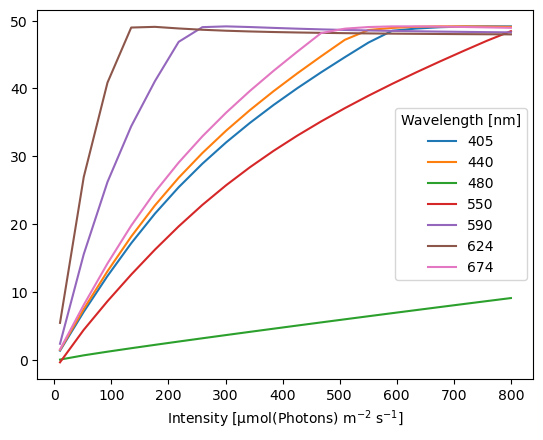

In [13]:
O2s.plot()

In [10]:
if settings["CO2_fluxes_monochrom"]["plot"]:
    O2s = fnc.load_obj_dated("O2production_wi", results_path)

    fig, ax = fnc.plot_heatmap(CO2s, clab="Net CO$_2$ consumption rate [mmol mol(Chl)$^{-1}$ s$^{-1}$]")
    ax.set_title("CO$_2$ consumption under near-monochromatic lights")
    ax = fnc.add_na_annotation(ax, CO2s, 6)
    fig.tight_layout()
    fnc.savefig_dated(fig, "O2prod_singlemonochr", type=plot_format, path=figure_path)

FileNotFoundError: No file with the structure 'XXXXXXXX_O2production_wi.dill' found in results